# <a name="0.0"></a>Содержание:
* [Описание проекта](#0.)
    - [Описание данных](#0.1.)
* [Шаг 1. Загружаем и подготавливаем данные](#1.)
    - [Вывод](#1.1.)
* [Шаг 2. Обучаем разные модели](#2.)
* [Шаг 3. Анализируем скорость и качество моделей](#3.)
    - [Линейная регрессия](#3.1.)
    - [Решающее дерево](#3.2.)
    - [Случайный лес](#3.3.)
    - [Градиентный бустинг](#3.4.)
    - [Оценка значимости признаков](#3.5.)
    - [Вывод](#3.6.)

<a name="0."></a>
# Описание проекта

Для сервиса по продаже автомобилей разрабатывается система по прогнозированию рыночной цены автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей используем метрику RMSE

<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="0.1."></a>
## Описание данных:

Входные данные:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)
<br>

<font size="2">([к содержанию](#0.0))</font>

<a name="1."></a>
# Шаг 1. Загружаем и подготавливаем данные


<font size="2">([к содержанию](#0.0))</font>

In [1]:
import pandas as pd

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import cross_val_score
import random

In [2]:
data = pd.read_csv('datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
# Отбросим лишние столбцы с датами
data.drop(['DateCrawled', 'DateCreated', 'LastSeen'],
          axis=1, inplace=True)

In [6]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [7]:
data[['RegistrationYear']].value_counts().sort_index().head(20)

RegistrationYear
1000                 37
1001                  1
1039                  1
1111                  3
1200                  1
1234                  4
1253                  1
1255                  1
1300                  2
1400                  1
1500                  5
1600                  2
1602                  1
1688                  1
1800                  5
1910                101
1915                  1
1919                  1
1920                  1
1923                  2
dtype: int64

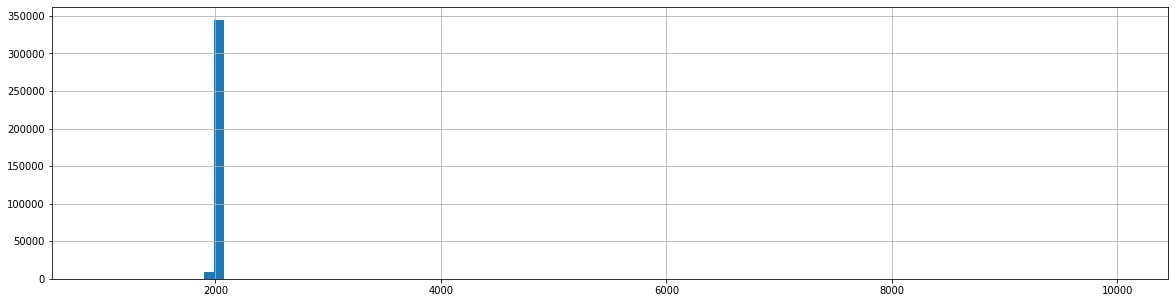

In [8]:
plt.figure(figsize=(20, 5))
data['RegistrationYear'].hist(bins=100)
plt.show()

In [9]:
empty_values_RegistrationYear = data['RegistrationYear'].isna().sum()
if empty_values_RegistrationYear == 0:
    print('Пустых значений не обнаружено')
else:
    print(f'Найдено {empty_values_RegistrationYear} значений')

Пустых значений не обнаружено


In [10]:
# Оставим только валидные даты
data = data.query('1970 <= RegistrationYear < 2021')

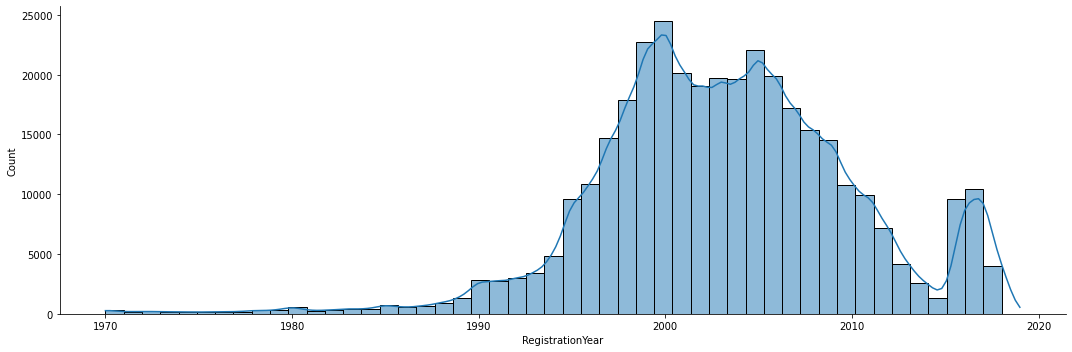

In [11]:
sns.displot(data['RegistrationYear'], bins=50, kde=True, aspect=3)

In [12]:
data.Gearbox.value_counts()

manual    267478
auto       66101
Name: Gearbox, dtype: int64

In [13]:
# Devel Sixteen (5000 л. с.) самый мощный двигатель, но у нас же не спорт кары
data.Power.value_counts().reset_index().sort_values(by='index')

,index,Power
0,0,39579
229,1,33
304,2,10
315,3,8
239,4,30
...,...,...
473,17932,1
484,19208,1
487,19211,1
606,19312,1


In [14]:
data = data.query('Power < 600')

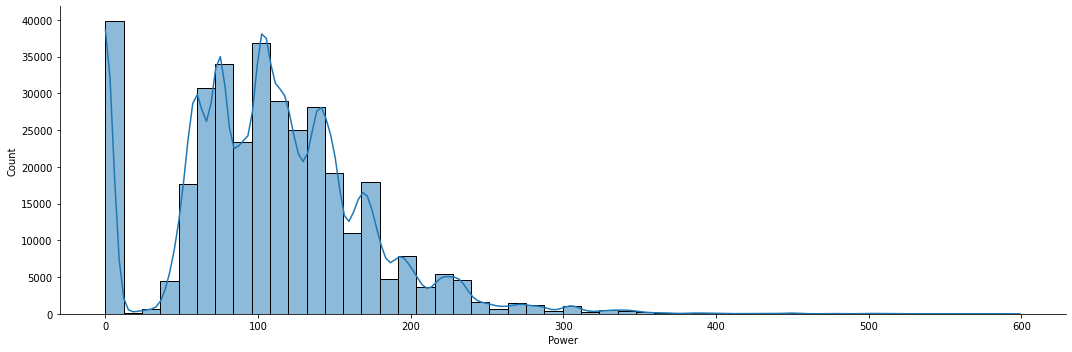

In [15]:
sns.displot(data['Power'], bins=50, kde=True, aspect=3)

Строки с мощностью равной 0 обрабатывать не будем, так как заполнение медианным значением может привести к ошибке второго рода.

In [16]:
data.Model.value_counts()

golf                  29192
other                 23850
3er                   19738
polo                  13044
corsa                 12545
                      ...  
serie_2                   5
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [17]:
data.Kilometer.value_counts()

150000    237666
125000     36350
100000     14711
90000      11485
80000       9986
70000       8519
60000       7371
50000       6159
5000        6002
40000       4864
30000       4379
20000       3925
10000       1132
Name: Kilometer, dtype: int64

In [18]:
data.RegistrationMonth.value_counts().reset_index().sort_values(by='index')

,index,RegistrationMonth
0,0,36862
10,1,23022
12,2,21183
1,3,34236
3,4,29170
4,5,29047
2,6,31354
5,7,26996
11,8,22552
9,9,23737


In [19]:
data.FuelType.value_counts()

petrol      215216
gasoline     98591
lpg           5302
cng            562
hybrid         231
other          187
electric        88
Name: FuelType, dtype: int64

In [20]:
data.Brand.value_counts()

volkswagen        76764
opel              39751
bmw               36835
mercedes_benz     31890
audi              29405
ford              25013
renault           17881
peugeot           10974
fiat               9559
seat               6895
mazda              5606
skoda              5489
smart              5240
citroen            5112
nissan             4935
toyota             4600
hyundai            3583
mini               3195
volvo              3168
mitsubishi         3014
sonstige_autos     2973
honda              2812
kia                2462
suzuki             2321
alfa_romeo         2298
chevrolet          1704
chrysler           1422
dacia               899
daihatsu            806
subaru              757
porsche             736
jeep                657
daewoo              541
land_rover          539
saab                525
trabant             518
jaguar              497
rover               484
lancia              464
lada                225
Name: Brand, dtype: int64

In [21]:
data.NotRepaired.value_counts()

no     246295
yes     35867
Name: NotRepaired, dtype: int64

In [22]:
data.NumberOfPictures.value_counts()

0    352549
Name: NumberOfPictures, dtype: int64

In [23]:
# Данный столбец равен нулю для всех instances, поэтому удалим его
data.drop(['NumberOfPictures'],
          axis=1,
          inplace=True)

In [24]:
data.PostalCode.value_counts()

10115    818
65428    613
66333    342
32257    317
44145    315
        ... 
96367      1
25599      1
55499      1
55432      1
63874      1
Name: PostalCode, Length: 8142, dtype: int64

In [25]:
# Этот столбец не несёт много полезной информации
data.drop('PostalCode', axis=1, inplace=True)

In [26]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [27]:
#В данных столбцах есть пропуски 
data.isna().sum()

Price                    0
VehicleType          37068
RegistrationYear         0
Gearbox              19328
Power                    0
Model                19131
Kilometer                0
RegistrationMonth        0
FuelType             32372
Brand                    0
NotRepaired          70387
dtype: int64

Пустые значения в столбце NotRepaired заполним новым значением unknown, который соответствует ситуации продажи автомобиля со вторых рук

In [28]:
data['NotRepaired'].fillna('unknown', inplace=True)

In [29]:
data.isna().sum()

Price                    0
VehicleType          37068
RegistrationYear         0
Gearbox              19328
Power                    0
Model                19131
Kilometer                0
RegistrationMonth        0
FuelType             32372
Brand                    0
NotRepaired              0
dtype: int64

Заполнять пропуски в столбце VehicleType нельзя, так как у нас нет информации о его связях с другими признаками, поэтому просто дропнем

In [30]:
data['VehicleType'].value_counts()

sedan          90927
small          79644
wagon          65057
bus            28716
convertible    20072
coupe          15970
suv            11905
other           3190
Name: VehicleType, dtype: int64

In [31]:
data = data[~data['VehicleType'].isna()]

In [32]:
data = data[~data.VehicleType.isna()]

In [33]:
data.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox               9668
Power                    0
Model                12500
Kilometer                0
RegistrationMonth        0
FuelType             15398
Brand                    0
NotRepaired              0
dtype: int64

In [34]:
gearbox_unique = data['Gearbox'].value_counts()
gearbox_unique

manual    243764
auto       62049
Name: Gearbox, dtype: int64

In [35]:
probability = gearbox_unique[0] / (gearbox_unique[0] + gearbox_unique[1])
probability

0.7971014966662634

In [36]:
def bernoulli_trail(p):
    return 'manual' if random.random()<p else 'auto'

def fillGearbox(row):
    if pd.isnull(row['Gearbox']):
        return bernoulli_trail(probability)
    else:
        return row['Gearbox']

In [37]:
# Пропуски в коробках передач заполним случайными величинами, полученными по распределению бернулли
data['Gearbox'] = data.apply(fillGearbox, axis=1)   

In [38]:
#В данных столбцах есть пропуски 
data.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                12500
Kilometer                0
RegistrationMonth        0
FuelType             15398
Brand                    0
NotRepaired              0
dtype: int64

In [39]:
# Остальных пропусков мало, поэтому дропнем их
data.dropna(inplace=True)

In [40]:
# Стоимость до 100 евро следует отбросить
data['Price'].value_counts().reset_index().sort_values(by='index').head(100)

,index,Price
0,0,5252
155,1,519
1165,2,6
1562,3,3
1090,5,8
...,...,...
3078,202,1
3038,205,1
1996,209,2
1145,210,6


In [41]:
data = data.query('Price > 100')

In [42]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


In [43]:
data.reset_index(drop=True, inplace=True)

In [44]:
# Выделим столбцы с категориальными признаками
cat_features=['VehicleType', 'Gearbox',
              'Model', 'FuelType',
              'Brand', 'NotRepaired']
data_cat_features = data[cat_features]
data_not_cat_features = data.drop(cat_features, axis=1)

In [45]:
# Специально для линейной регрессии
data_for_linear = data.copy()

In [46]:
# Кодируем категориальные признаки
encoder = OrdinalEncoder()
data_cat_features = pd.DataFrame(encoder.fit_transform(data_cat_features),
                                 columns=data_cat_features.columns)
# Объединим DataFrames
data = pd.merge(data_not_cat_features, data_cat_features,
                left_index=True, right_index=True)

In [47]:
data_for_linear = pd.get_dummies(data_for_linear[cat_features], drop_first=True)
data_for_linear = pd.merge(data_not_cat_features, data_for_linear,
                           left_index=True, right_index=True)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283580 entries, 0 to 283579
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              283580 non-null  int64  
 1   RegistrationYear   283580 non-null  int64  
 2   Power              283580 non-null  int64  
 3   Kilometer          283580 non-null  int64  
 4   RegistrationMonth  283580 non-null  int64  
 5   VehicleType        283580 non-null  float64
 6   Gearbox            283580 non-null  float64
 7   Model              283580 non-null  float64
 8   FuelType           283580 non-null  float64
 9   Brand              283580 non-null  float64
 10  NotRepaired        283580 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 23.8 MB


In [49]:
data['Price'].describe()

count    283580.000000
mean       4909.589333
std        4603.586838
min         101.000000
25%        1400.000000
50%        3250.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

<a name="1.1."></a>
## Вывод:

Исходный набор данных представляет собой таблицу размера 354369 x 13, в которой присутствует большое количество пропусков и малозначимых признаков. Первоначально из таблицы были удалены столбцы, которые характеризовали:
-	DateCrawled – дату скачивания БД
-	DateCreated – дату создания анкеты
-	LastSeen – активность пользователя

При исследовании месяца регистрации автомобиля было обнаружено, что в данных имеется большое количество некорректных значений, так имеются автомобили, зарегистрированные на 1000 год и на 9999 год. Очевидно, что это ошибка возникает при формировании или выгрузке БД. Для формирования рабочей БД мы ограничили диапазон с 1970 по 2021. В результате функция распределения записей по году регистрации получилась похожей на нормальное распределение со смещением вправо.

При анализе записей по мощности двигателей были также обнаружены аномалии, так в записях присутствуют машины с мощностью двигателя равной 0 или более 5000 л.с. В качестве ограничения оставим только записи с мощностью меньше 600. График распределения получился похожим на нормальное со смещением влево. Отбрасывать или заполнять медианными значениями записи, в которых мощность равняется 0 нельзя, так как это может привести к тому, что модель обнаружит зависимости, которых нет, т.е. усилится ошибка второго рода.
Значения в столбце с количеством прикреплённых фотографий к анкете равны 0 для всех записей. Поэтому мы его отбросили.

Столбец с почтовым индексом владельца вероятнее всего ничего не говорит о цене автомобиля, поэтому мы его отбросили.

В столбце, отвечающем за признак наличия ремонта автомобиля пустые значения заполнили параметром unknown, чтобы не приводить к смещению данных.

Для заполнения пропусков в столбце о типе коробки передач мы используем распределение Бернулли. Вероятность того, что автомобиль в анкете имеет коробку автомат равна ~ 20%.

Строки с пропусками в столбцах о типе автомобильного кузова, модели и типе топлива отбросим, так как их немного (4.1%, 3.5%, 4.3% от общего числа)

Анкеты, в которых цена автомобиля меньше 100 евро также отбросим как невалидные.

Признаки:
- VehicleType – тип кузова
- Gearbox – тип коробки передач
-  Model – модель автомобиля
- FuelType – тип топлива
- Brand – марка автомобиля
- NotRepaired – признак наличия ремонта

определяем как категориальные и используем OrdinalEncoder для кодирования признаков с помощью списка целых чисел


<font size="2">([к содержанию](#0.0))</font>

<a name="2."></a>
# Шаг 2. Обучаем разные модели


<font size="2">([к содержанию](#0.0))</font>

In [50]:
train, test = train_test_split(data, random_state=0)
train_linear, test_linear = train_test_split(data_for_linear,
                                             random_state=0)

In [51]:
X_train = train.drop('Price', axis=1)
y_train = train['Price']

X_test = test.drop('Price', axis=1)
y_test = test['Price']

X_train_linear = train_linear.drop('Price', axis=1)
y_train_linear = train_linear['Price']

X_test_linear = test_linear.drop('Price', axis=1)
y_test_linear = test_linear['Price']

In [52]:
# Количественные признаки
quan_features = X_train.drop(cat_features,
                             axis=1).columns

In [53]:
# Масштабируем только числовые признаки
scaler = StandardScaler()
X_train[quan_features] = scaler.fit_transform(X_train[quan_features])
X_test[quan_features] = scaler.transform(X_test[quan_features])

In [54]:
# Масштабируем только числовые признаки для линейной регрессии
X_train_linear[quan_features] = scaler.transform(X_train_linear[quan_features])
X_test_linear[quan_features] = scaler.transform(X_test_linear[quan_features])

In [55]:
%%time
linear_model = LinearRegression()
scores = cross_val_score(linear_model,
                         X_train_linear,
                         y_train_linear,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1, cv=5)
print('RMSE линейной регрессии:', abs(scores.mean()) ** 0.5)

RMSE линейной регрессии: 2477.3351974302695
Wall time: 16.3 s


In [56]:
%%time
forest_base_model = RandomForestRegressor()
forest_params={
    'n_estimators': [x for x in range(5, 200, 5)],
    'max_depth': [x for x in range(1, 5, 1)]
}
forest_model = GridSearchCV(
    estimator=forest_base_model,
    param_grid=forest_params,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5)
forest_model.fit(X_train, y_train)
print('RMSE случайного леса:', abs(forest_model.best_score_) ** 0.5)

RMSE случайного леса: 2460.9876857202435
Wall time: 31min 2s


In [57]:
%%time
tree_base_model = DecisionTreeRegressor()
tree_params = {'max_depth': [x for x in range(1, 10, 2)]}
tree_model = GridSearchCV(
    estimator=tree_base_model,
    param_grid=tree_params,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5)
tree_model.fit(X_train, y_train)
print('RMSE решающего дерева:', abs(tree_model.best_score_) ** 0.5)

RMSE решающего дерева: 2002.6379088094725
Wall time: 2.26 s


In [58]:
%%time
gb_base_model = LGBMRegressor()
gb_params = {
    'max_depth': [x for x in range(2, 60, 5)],
    'n_estimators': [x for x in range(5, 200, 5)],
    'learning_rate': [x / 100 for x in range(10, 80, 10)]
}
gb_model = GridSearchCV(estimator=gb_base_model,
                        param_grid=gb_params,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        cv=5)
gb_model.fit(X_train, y_train)
print('RMSE градиентного бустинга:', abs(gb_model.best_score_) ** 0.5)

RMSE градиентного бустинга: 1541.2464820952666
Wall time: 1h 14min 55s


<a name="3."></a>
# Шаг 3. Анализируем скорость и качество моделей


<font size="2">([к содержанию](#0.0))</font>

<a name="3.1."></a>
## Линейная регрессия


<font size="2">([к содержанию](#0.0))</font>

In [59]:
%%time
linear_model_best = LinearRegression()
linear_model_best.fit(X_train_linear,
                      y_train_linear)

Wall time: 3.39 s


LinearRegression()

In [60]:
%%time
linear_model_best.predict(X_test_linear)

Wall time: 126 ms


array([ 2995.02471381, 12184.73530392,  5921.45194976, ...,
        2218.66627501,  1572.49738938,  8288.74926297])

In [61]:
print("RMSE логической регрессии: тестовый {:.3f}".format(
    mean_squared_error(linear_model_best.predict(X_test_linear), y_test_linear) ** 0.5))

RMSE логической регрессии: тестовый 2477.447


<a name="3.2."></a>
## Решающее дерево


<font size="2">([к содержанию](#0.0))</font>

In [62]:
%%time
tree_model_best = DecisionTreeRegressor(max_depth=tree_model.best_params_['max_depth'],
                                        random_state=0)
tree_model_best.fit(X_train,y_train)

Wall time: 393 ms


DecisionTreeRegressor(max_depth=9, random_state=0)

In [63]:
%%time
tree_model_best.predict(X_test)

Wall time: 12 ms


array([ 1897.58961768, 12932.125     ,  5238.97626527, ...,
        1131.7332701 ,  6098.97368421,  8190.64473684])

In [64]:
print("RMSE решающее дерево: тестовый {:.3f}".format(
    mean_squared_error(tree_model_best.predict(X_test), y_test) ** 0.5))

RMSE решающее дерево: тестовый 1984.716


<a name="3.3."></a>
## Случайный лес


<font size="2">([к содержанию](#0.0))</font>

In [65]:
%%time
forest_model_best = RandomForestRegressor(max_depth=forest_model.best_params_['max_depth'],
                                          n_estimators=forest_model.best_params_['n_estimators'],
                                          random_state=0)
forest_model_best.fit(X_train, y_train)

Wall time: 6.69 s


RandomForestRegressor(max_depth=4, n_estimators=50, random_state=0)

In [66]:
%%time
forest_model_best.predict(X_test)

Wall time: 99.7 ms


array([1639.73831574, 7093.83192063, 4148.12170358, ..., 1639.73831574,
       4540.25033572, 8888.70313635])

In [67]:
print("RMSE ансабля деревьев: тестовый {:.3f}".format(
    mean_squared_error(forest_model_best.predict(X_test), y_test) ** 0.5))

RMSE ансабля деревьев: тестовый 2457.797


<a name="3.4."></a>
## Градиентный бустинг


<font size="2">([к содержанию](#0.0))</font>

In [68]:
%%time
gb_model_best = LGBMRegressor(learning_rate=gb_model.best_params_['learning_rate'], 
                              max_depth=gb_model.best_params_['max_depth'],
                              n_estimators=gb_model.best_params_['n_estimators'],
                              random_state=0)
gb_model_best.fit(X_train, y_train)

Wall time: 905 ms


LGBMRegressor(learning_rate=0.3, max_depth=22, n_estimators=195, random_state=0)

In [69]:
%%time
gb_model_best.predict(X_test)

Wall time: 188 ms


array([ 2014.16642935, 10097.57308909,  5163.66651823, ...,
        1439.89241946,  3729.24080785,  7714.00116008])

In [70]:
print("RMSE градиентного бустинга: тестовый {:.3f}".format(
    mean_squared_error(gb_model_best.predict(X_test), y_test) ** 0.5))

RMSE градиентного бустинга: тестовый 1515.050


<a name="3.5."></a>
## Оценка значимости признаков


<font size="2">([к содержанию](#0.0))</font>

In [71]:
stat = pd.DataFrame(gb_model_best.feature_importances_,
                    index=X_train.columns)

In [72]:
stat = stat.sort_values(by=0)

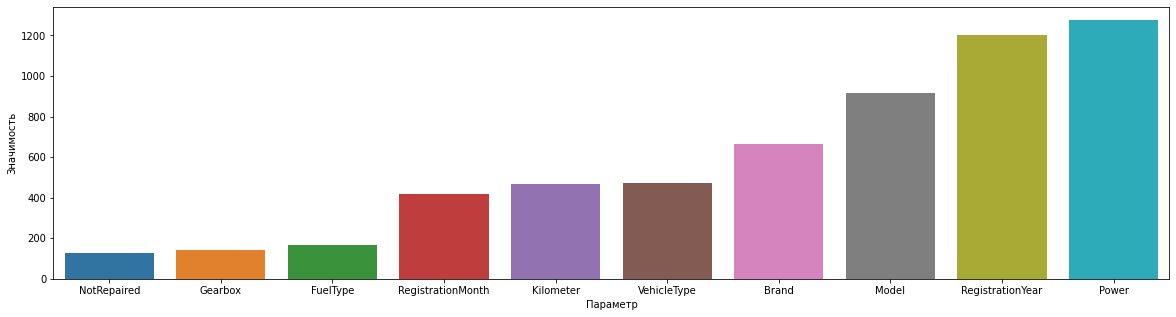

In [76]:
plt.figure(figsize=(20,5))
sns.barplot(x=stat.index, y=stat[0])
plt.xlabel('Параметр')
plt.ylabel('Значимость')
plt.show()

<a name="3.6."></a>
## Вывод

Исходный набор данных представляет собой таблицу размера (354369, 16). В исходном наборе данных имеется юольшое количество пропусков (108555), которые были либо просто выброшены, либо соответствувющим образом заполнены. Для построения модели были отброшены столбцы с датами (DateCrawled,DateCreated, LastSeen) и малоинформативные признаки (PostalCode, NumberOfPictures).

Для анализа качества предсказания, скорости предсказания и времени обучения использовались следующие алгоритмы машинного обучения:


| Алгоритм| RMSE обучающий (cv)|RMSE тестовый|Время обучения (с)|Время предсказания (мс)|
| --------|:-------------:|:-----------:|:------------:| ----------------:|
|Линейная регрессия|2476|2477|3.18|135|
|Решающее дерево|2001|1983|0.343|14|
|Случайный лес|2693|2689|10.7|154|
|Градиентный бустинг|1539|1514|0.701|179|

Как видно из таблицы, наибольшую точность в  прогнозах даёт алгоритм градиентного бустинга, он обучается так же быстро как и решающее дерево, но делает более точные прогнозы. Данный алгоритм больше всего подходит для составлення финальной модели. Если необходимо быстро построить модель и оценить результат, то можно использовать решающее дерево, так как оно даёт более высокую точноть, по сравнению с линейной регрессией и обучается гараздо быстрее ансамбля и бустинга.

Исходя из анализа результатов градиентного бустинга видно, что при установке цены следует акцентировать внивание на годе регистрации автомобиля, мощности двигателя, модели и бренде

<font size="2">([к содержанию](#0.0))</font>